# Advantages of Transformers over traditional RNN or LSTM or GRU

1. Transformers are very fast as compared to LSTM or GRU, because unlike RNN we process multiple words in parallel at a time. Thanks to multi-head self-attention mechanism.
2. Transformers can long-range dependencies in a sentence. Hence better at handling longer sequences as compare to LSTM.
3. Transformers also embeds positional information of word into word embedding.
4. Combination of high and low-level information with skip-connections of course! They enable top-down understanding to flow back with the multiple gradient paths that flow backward.
5. With the help of self-attention mechanism transformers are able to learn meaning based on context i.e. embedding vectors can vary for same word across sentences.

# Encoder

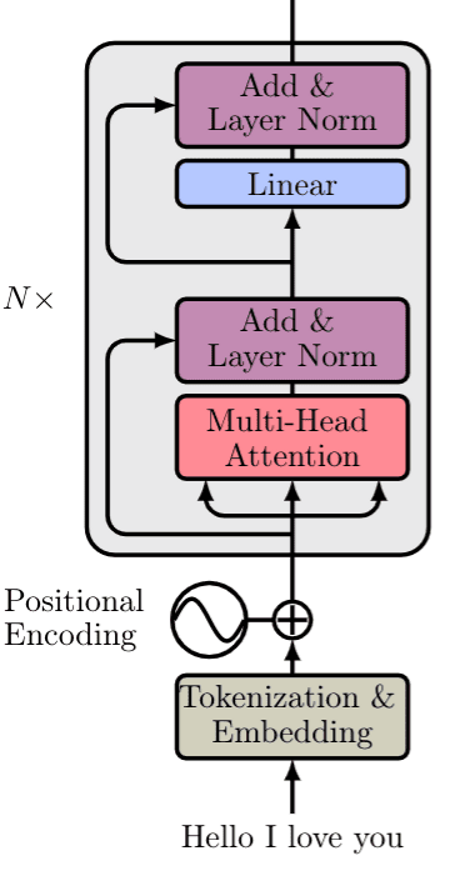

We will go block by block:

## Tokenization

The transformer revolution started with a simple question: Why don’t we feed the entire input sequence? No dependencies between hidden states! That might be cool!
As an example the sentence “hello, I love you”:

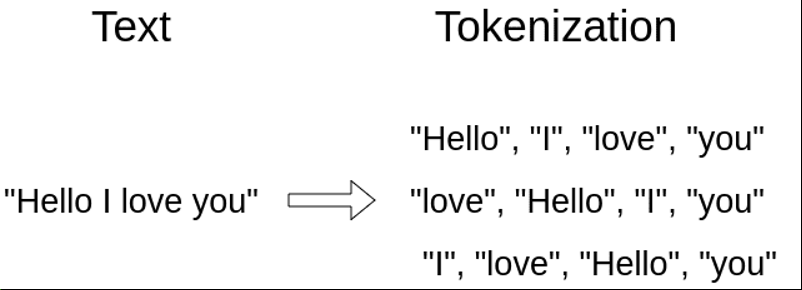

Tokenization of above text can be in any order as it uses sets and for set order is irrelevant.

We denote the input set as X=x1​,x2​,x3​…,xN​ where x∈RN×dmodel​. The elements of the sequence xi​ are referred to as tokens.
After tokenization, we project words in a distributed geometrical space, or simply build word embeddings.


In [1]:
from torch import nn
from transformers import AutoConfig, AutoTokenizer

model_ckpt = "bert-base-uncased"
text = "time flies like an arrow"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

## Word embedding

In general, an embedding is a representation of a symbol (word, character, sentence) in a distributed low-dimensional space of continuous-valued vectors.
Words are not discrete symbols. They are strongly correlated with each other. That’s why when we project them in a continuous Euclidean space we can find associations between them.
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension **dmodel(in paper it is 512) but BERT uses 768 as embedding dimension**<br>
	
Ideally, an embedding captures the semantics of the input by placing semantically similar inputs close together in the embedding space.

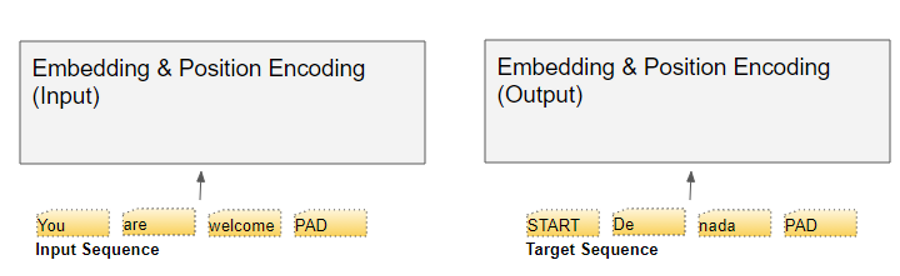

In natural language, we can find similar word meanings or even similar syntactic structures (i.e. objects get clustered together). In any case, when you project them in 2D or 3D space you can visually identify some clusters. 

In [2]:
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

Embedding(30522, 768)

In [3]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [4]:
AutoConfig.from_pretrained("distilbert-base-uncased")

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 30522
}

In [5]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 5, 768])

## Positional encodings
When you convert a sequence into a set (tokenization), you lose the notion of order.<br>
Can you find the order of words (tokens) from the sequence: “Hello I love you”? Probably yes! But what about 30 unordered words?
Remember, machine learning is all about scale. The neural network certainly cannot understand any order in a set.
	
Since transformers process sequences as sets, they are, in theory, permutation invariant.
Let’s help them have a sense of order by slightly altering the embedding based on the position. 
*Officially, positional encoding is a set of small constants, which are added to the word embedding vector before the first self-attention layer.*
So if the same word appears in a different position, the actual representation will be slightly different, depending on where it appears in the input sentence.

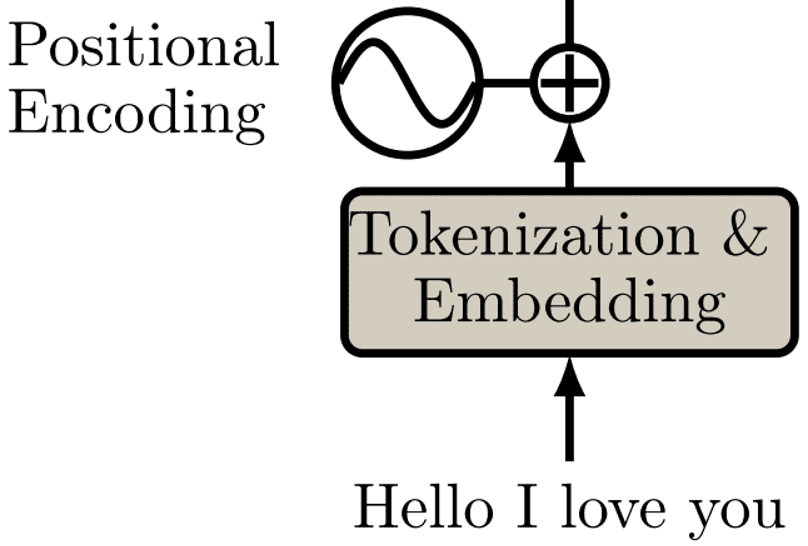

In other words, it interleaves a sine curve and a cos curve, with sine values for all even indexes and cos values for all odd indexes.
Sine or cosine curves value does not depend on length of the sentence nor it increases as its positional index increases.
In the transformer paper, the authors came up with the sinusoidal function for the positional encoding. The sine function tells the model to pay attention to a particular wavelength λ. Given a signal y(x)=sin(kx) the wavelength will be k=2π/λ​. In our case the λ will be dependent on the position in the sentence. i is used to distinguish between odd and even positions.

Mathematically:

$$
PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})
$$


- pos is the position of the word in the sequence
- $d_{model}$ is the length of the encoding vector (same as the embedding vector) and
- *i* is the index value into this vector(embedding vector).

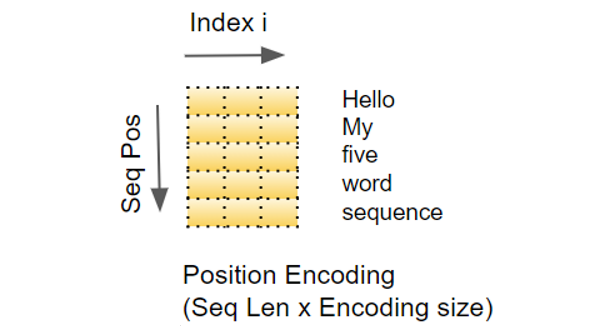

For the record, 512=$d_{model}$​ , which is the dimensionality of the embedding vectors.

## Why sinusoidal?

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. Could you figure out what kind of issues it would cause? One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training. In addition, our model may not see any sample with one specific length which would hurt generalization of our model.

Ideally, the following criteria should be satisfied:
- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

These all criteria are satisfied by sinusoidal function. Each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000×2π.

Another characteristic of sinusoidal positional encoding is that it allows the model to attend relative positions effortlessly. 


In [6]:
class Embeddings(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)

        # Positional encodings
        pos = torch.arange(0, config.max_position_embeddings, dtype=torch.float).unsqueeze(1)
        self.position_embeddings = torch.zeros(config.max_position_embeddings, config.hidden_size)
        _2i = torch.arange(0, config.hidden_size, step=2).float()
        self.position_embeddings[:,0::2] = torch.sin(pos / (10000 **(_2i/config.hidden_size)))
        self.position_embeddings[:,1::2] = torch.cos(pos / (10000 **(_2i/config.hidden_size)))
        self.position_embeddings = self.position_embeddings.unsqueeze(0)

        
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps = 1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings[:,:seq_length]

        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)

        embeddings = self.dropout(embeddings)
        return embeddings

In [7]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

NameError: name 'torch' is not defined

## Attention

Intuition Behind Q,K,V
Key-value-query concepts come from information retrieval systems.<br>
Let’s start with an example of searching for a video on YouTube.<br>

When you search (query) for a particular video, the search engine will map your query against a set of keys (video title, description, etc.) associated with possible stored videos. Then the algorithm will present you the best-matched videos (values). This is the foundation of content/feature-based lookup.
In the single video retrieval, the attention is the choice of the video with a maximum relevance score.<br>
Bringing this idea closer to the transformer’s attention we have something like this:

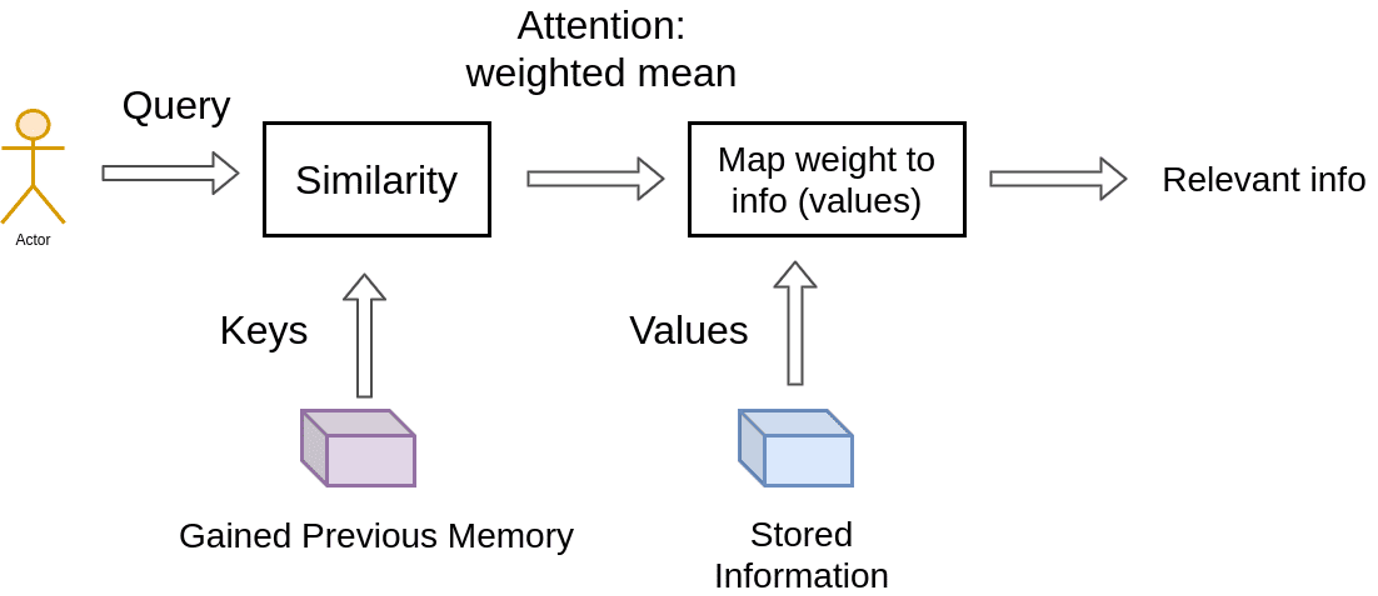

Now we got intuition of Query, Keys and Values matrix. Now we will understand  what it contains:<br>
Basically Q,K,V contains embedding + positional encodings(N x $d_{model}$) that are input to it. 

Each of these matrix are multiplied by its weight matrix of shape ($d_{k}$ x $d_{model}$).
Here:
- N: this is length of vocabulary
- $d_{k}$: This is the embedding size  (i.e. $d_{model}$ in case of single head h=1 self-attention). 
- $d_{model}$ : This is the dimension of embedding vector.

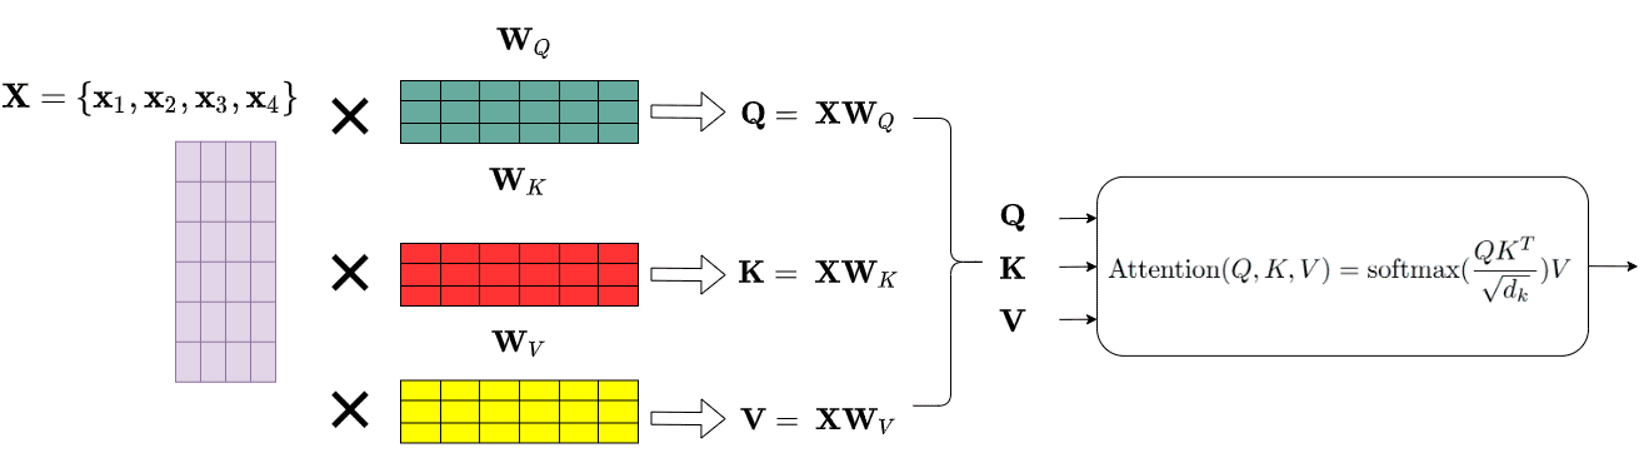

The Queries, Keys and Values of the embedding matrix can easily be done by multiplying our input $X∈R^{N×d_{k}}$​ with 3 different weight matrices $W_{K}$​ and $W_{Q}$ ∈ $R^{d_{k}​×d_{model}}​  and $W_{v} ∈ R^{d_{v}×d_{model}}$​ . In essence, it's just a matrix multiplication in the original word embeddings. 

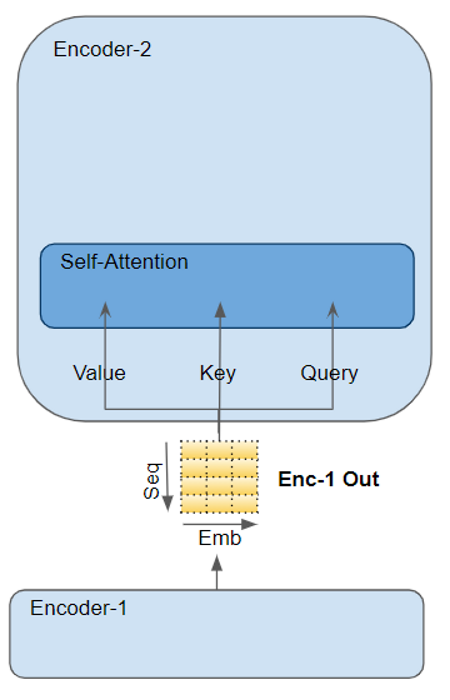

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.<br>

**Here output from  $softmax(\frac{QK^{T}}{\sqrt{d_{k}}})$ acts as filter which is applied on Values matrix so that it can give weightage(attention) to expected tokens only.**

### Scaled Dot-Product Attention

Original paper of transformer uses "Scaled Dot-Product Attention". The input consists of queries and keys of dimension $d_{k}$, and values of dimension dv. We compute the dot products of the query with all keys, divide each by $\sqrt{d_{k}}$, and apply a softmax function to obtain the weights on the values. In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . 

We compute the matrix of outputs as: 

$$
Attention(Q, K, V ) = softmax(\frac{QK^{T}}{\sqrt{d_{k}}})V
$$

The two most commonly used attention functions are **additive attention**, and **dot-product (multiplicative) attention**. Dot-product attention is identical to our algorithm, except for the scaling factor of $\sqrt{d_{k}}$ . Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. <br>
While the two are similar in theoretical complexity, **dot-product attention is much faster and more space-efficient in practice**, since it can be implemented using highly optimized matrix multiplication code. 
While for small values of $d_{k}$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_{k}$. We suspect that for large values of $d_{k}$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients . To counteract this effect, we scale the dot products by  $\sqrt{d_{k}}$. 

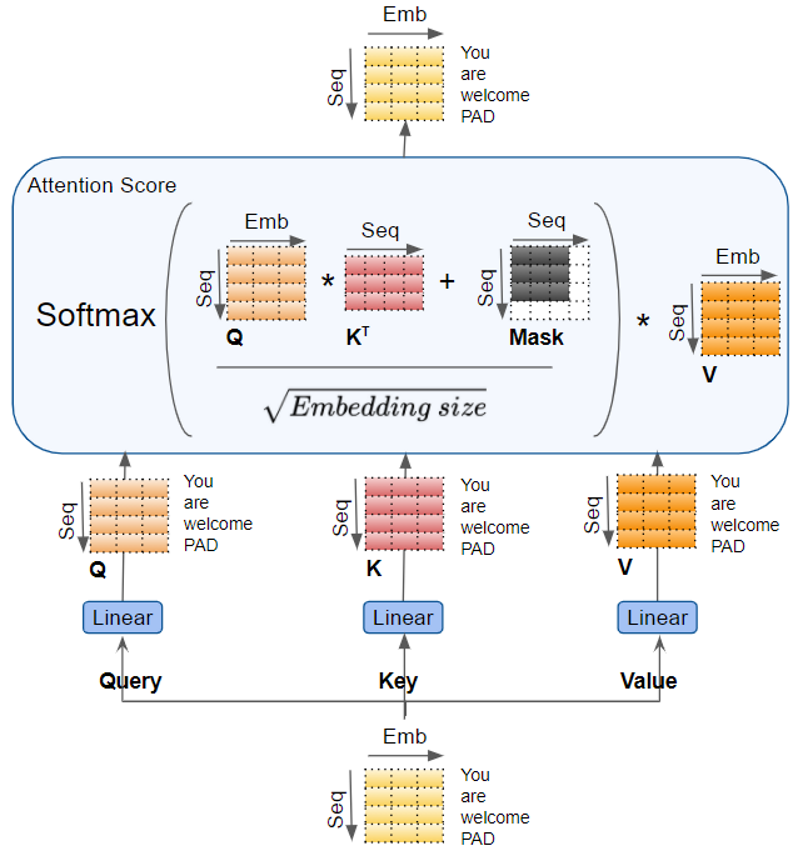

Above image depicts shape of matrix throughout attention mechanism (for better representation first dimension "size of sample" is ignore but it is there).

In [8]:
import torch
from math import sqrt
query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2))/sqrt(dim_k)
scores.shape

torch.Size([1, 5, 5])

In [9]:
print(key.shape)
print(key.transpose(1,2).shape)

torch.Size([1, 5, 768])
torch.Size([1, 768, 5])


In [10]:
import torch.nn.functional as F
weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

tensor([[1., 1., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [11]:
weights.shape

torch.Size([1, 5, 5])

In [12]:
attn_outputs = torch.bmm(weights,value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [13]:
# Single head attention 
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def scaled_dot_product_attention(self, query, key, value, mask=None):
        dim_k = query.size(-1)
        scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
        if mask is not None:
            print(scores, scores.dtype)
            scores = scores.masked_fill(mask == 0, float("-inf"))
            print(scores, scores.dtype)
        weights = F.softmax(scores, dim=-1)
        return weights.bmm(value)

    def forward(self, query, key, value, mask=None):
        attn_outputs = self.scaled_dot_product_attention(
            self.q(query), self.k(key), self.v(value), mask
        )
        return attn_outputs

### Multi Head Attention

**An complicating consequence of putting a softmax function in attention is that it will tend to focus on a single element.** This is a limitation we didn’t have before. Sometimes it’s useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.

To address the above issues, the Transformer paper refined the self-attention layer by adding a mechanism called “multi-headed” attention. This improves the performance of the attention layer in two ways:

- It expands the model’s ability to focus on different positions. It would be useful if we’re translating a sentence like “The animal didn’t cross the street because it was too tired”, we would want to know which word “it” refers to.
- It gives the attention layer multiple “representation subspaces”. As we’ll see next, with multi-headed attention we have not only one, but multiple sets of Q,K,V weight matrices (the Transformer uses eight attention heads, so we end up with eight sets for each encoder/decoder). Each of these sets is randomly initialized. Then, after training, each set is used to project the input embedding (or vectors from lower encoders/decoders) into a different representation subspace.
- Multiple heads lets the the transformer consider several previous words simultaneously when predicting the next. It brings back the power we had before we pulled the softmax into the picture.

Mathematically,
$$
				MultiHead(Q, K, V ) = Concat(head1, ..., headh)W^{O}
$$
where $head_{i} = Attention(QW_{i}^{Q} , KW_{i}^{K}  , VW_{i}^{V})$<br>

Where the projections are parameter matrices <br>

$ W_{i}^{Q} ∈ R^{d_{model}×d_{k}} $,<br>
$ W_{i}^{K} ∈  R^{d_{model}×d_{k}} $,<br>
$ W_{i}^{V} ∈  R^{d_{model}×d_{v}} $ and <br>
$ W^{O} ∈ R^{hd_{v}×d_{model}}$<br>

In multi-head attention, we employ h = 8 parallel attention layers, or heads. For each of these we use $d_{k} = d_{v} = d_{model}/h = 64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim//num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, mask=None):
        x = torch.cat([h(query, key, value, mask) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [15]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds,inputs_embeds,inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

In [52]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)
sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"
viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])
head_view(attention, tokens, sentence_b_start, heads=[8])

<IPython.core.display.Javascript object>

## Short residual skip connections

With skip connections, we can “pass” our higher-level understanding of the last layers to the previous layers. This allows us to re-modulate how we understand the input. This is the same idea as human top-down understanding, which is nothing more than expectations.

Skip connections serve two purposes:

1. They help keep the gradient smooth, which is a big help for backpropagation. Attention is a filter, which means that when it’s working correctly it will block most of what tries to pass through it. The result of this is that small changes in a lot of the inputs may not produce much change in the outputs if they happen to fall into channels that are blocked. This produces dead spots in the gradient where it is flat, but still nowhere near the bottom of a valley. These saddle points and ridges are a big tripping point for backpropagation. Skip connections help to smooth these out. In the case of attention, even if all of the weights were zero and all the inputs were blocked, a skip connection would add a copy of the inputs to the results and ensure that small changes in any of the inputs will still have noticeable changes in the result. This keeps gradient descent from getting stuck far away from a good solution. 

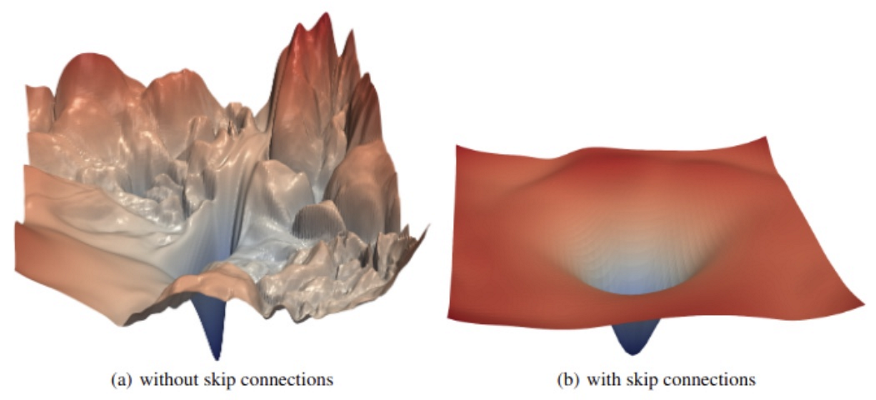

2. The second purpose of skip connections is specific to transformers — preserving the original input sequence. Even with a lot of attention heads, there’s no guarantee that a positional information will be present in those word vectors. It’s possible for the attention filter to forget entirely about the most recent word in favour of watching all of the earlier words that might be relevant. A skip connection takes the original word and manually adds it back into the signal, so that there’s no way it can be dropped or forgotten. This source of robustness may be one of the reasons for transformers’ good behaviour in so many varied sequence completion tasks.

In [16]:
# Feed forward layer

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [17]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_output)
ff_outputs.size()

torch.Size([1, 5, 768])

## Layer Normalization

In Layer Normalization (LN), the mean and variance are computed across channels and spatial dims. In language, each word is a vector. Since we are dealing with vectors we only have one spatial dimension.
Normalization is a step that pairs well with skip connections. There’s no reason they necessarily have to go together, but they both do their best work when placed after a group of calculations, like attention or a feed forward neural network.
The short version of layer normalization is that the values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one. The following diagram shows several distributions being normalized.

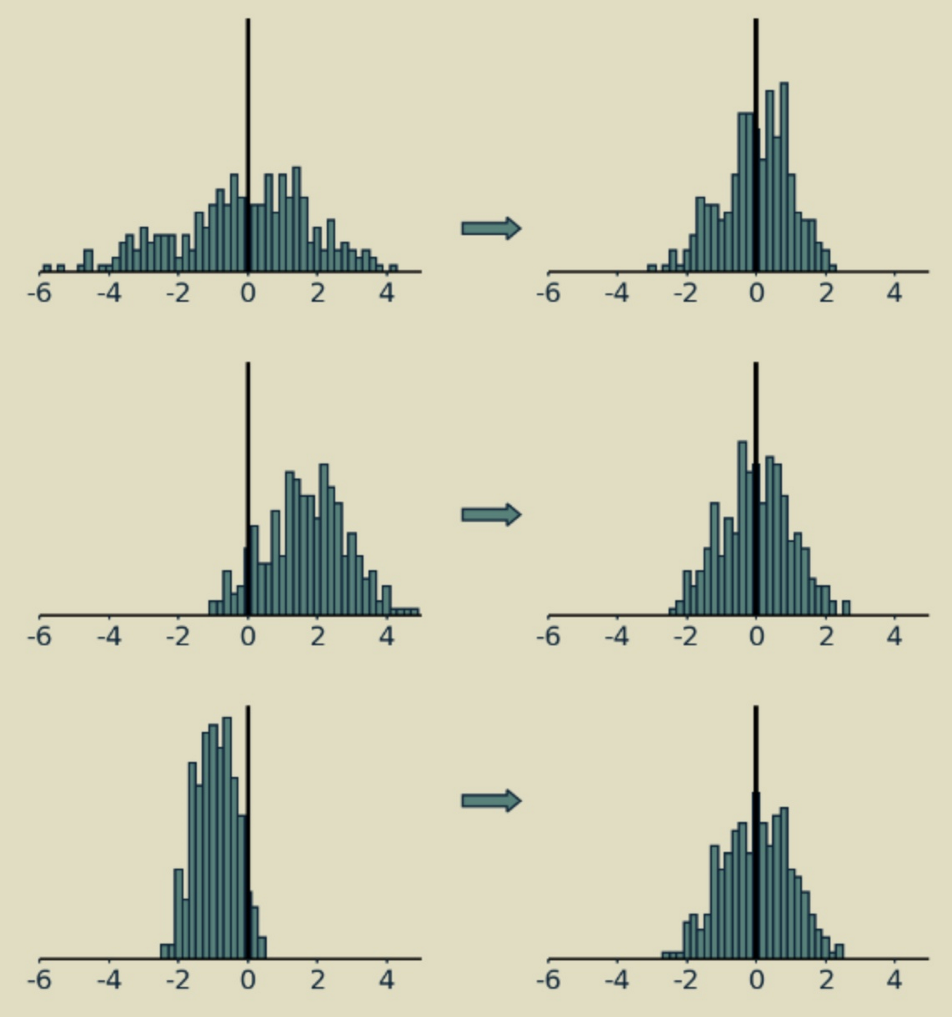

In a 4D tensor with merged spatial dimensions, we can visualize this with the following figure:

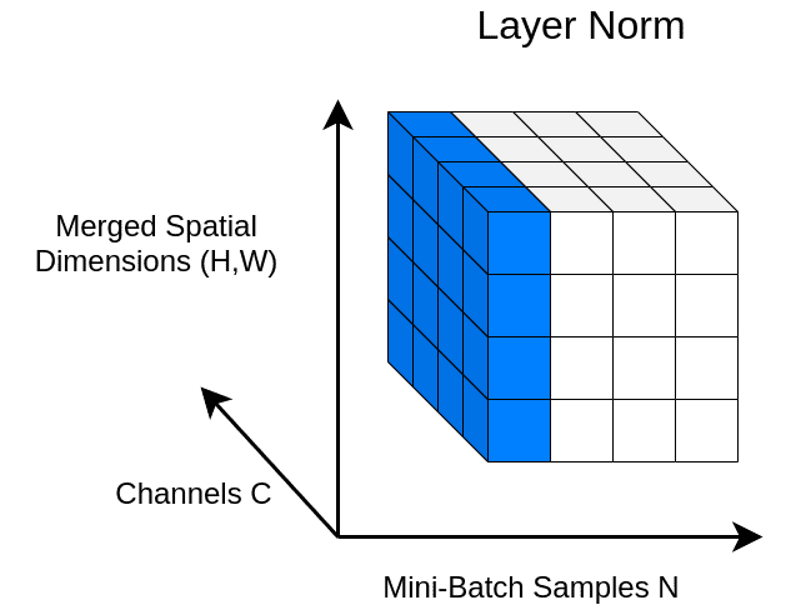

After applying a normalization layer and forming a residual skip connection we are here:

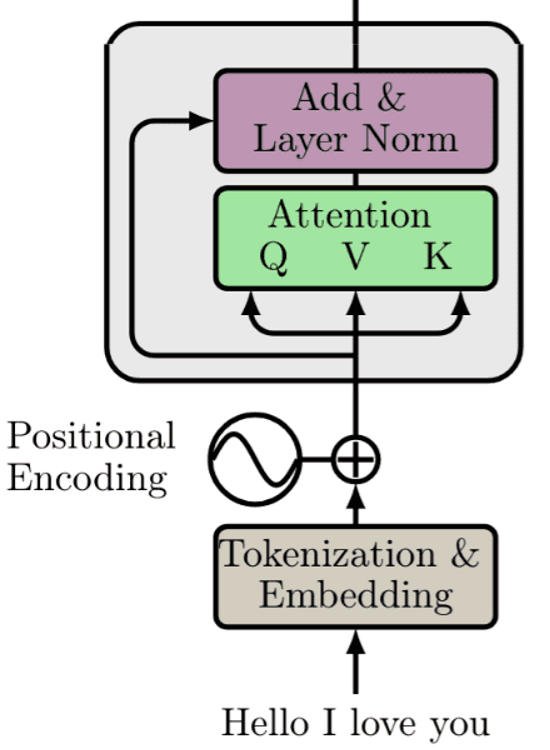

Even though this could be a stand-alone building block, the creators of the transformer add another linear layer on top and renormalize it along with another skip connection.


In [18]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply attention 
        hidden_state = self.attention(x,x,x)
        # Apply layer normalization  with a skip connectio
        x = self.layer_norm_1(x + hidden_state)
        # Apply feed-forward layer with a skip connection 
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

In [19]:
encoder_layer = TransformerEncoderLayer(config)
inputs_embeds.shape, encoder_layer(inputs_embeds).size()

(torch.Size([1, 5, 768]), torch.Size([1, 5, 768]))

## Linear layer

There are a lot of fancy ways to say trainable matrix multiplication; linear layer (PyTorch), dense layer (Keras), feed-forward layer (old ML books), fully connected layer.
$$
							y=xW^{T} + b
$$
	    				Where W is a weight matrix and y,x,b are vectors.
		
In fact, they add two linear layers with dropout and non-linearities in between.

The main intuition is that they project the output of self-attention in a higher dimensional space (X4 in the paper). This solves bad initializations and rank collapse. We have depicted it in the diagrams simply as Linear.

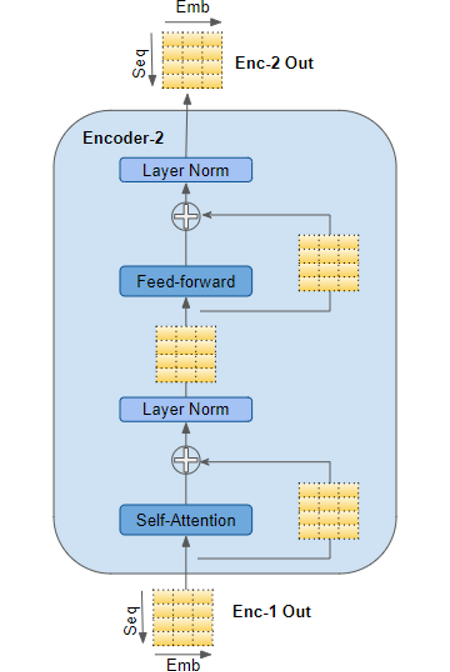


In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                    for _ in range(config.num_hidden_layers)])
    
    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [21]:
encoder = TransformerEncoder(config)
encoder(inputs.input_ids).size()

torch.Size([1, 5, 768])

## Adding a Classification Head
What we have built so far is the body, so if we wish to build a text classifier, we will need to attach a classification head to that body. We
have a hidden state for each token, but we only need to make one prediction. There are several options to approach this. Traditionally, the first token in such models is used for the prediction and we can attach a dropout and a linear layer to make a classification prediction.

In [140]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)


    def forward(self, x):
        x = self.encoder(x)[:,0,:] # Select hidden state of [cls] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [141]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

# Decoder

In [85]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len))
mask, mask.shape

(tensor([[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]),
 torch.Size([5, 5]))

In [32]:
scores.masked_fill(mask == 0, -float("inf"))

tensor([[[26.6471,    -inf,    -inf,    -inf,    -inf],
         [-0.3301, 29.0905,    -inf,    -inf,    -inf],
         [ 0.5719, -1.1881, 25.5358,    -inf,    -inf],
         [ 0.4444, -1.2821,  0.9220, 25.8561,    -inf],
         [-0.1094,  0.7567, -2.1396, -1.7350, 27.7206]]],
       grad_fn=<MaskedFillBackward0>)

In [22]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)

        self.cross_attn = MultiHeadAttention(config)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)

        self.feed_forward = FeedForward(config)
        self.layer_norm_3 = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x, enc_output, trg_mask, src_mask):
        # Self MultiHeadAttention Block
        x = self.layer_norm_1(x + self.dropout(self.attention(x, x, x, mask=trg_mask)))

        # Cross Attention block
        if enc_output is not None:
            x = self.layer_norm_2(x + self.dropout(self.cross_attn(x,enc_output,enc_output, mask=src_mask)))

        # Feed forward block
        x = self.layer_norm_3(x + self.dropout(self.feed_forward(x)))

        return x

In [23]:
import torch
src_vocab_size = 5000
tgt_vocab_size = 5000
src_data = torch.randint(1, src_vocab_size, (1, 5))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (1, 5))  # (batch_size, seq_length)
print(src_data.shape, tgt_data.shape)

torch.Size([1, 5]) torch.Size([1, 5])


In [24]:
def generate_mask(src, tgt):
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = torch.tril(torch.ones(seq_length, seq_length)).bool()
    tgt_mask = tgt_mask & nopeak_mask
    return src_mask, tgt_mask

src_mask,tgt_mask = generate_mask(src_data, tgt_data)
print(src_mask, tgt_mask)

tensor([[[[True, True, True, True, True]]]]) tensor([[[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]]])


In [12]:
encoded_output.shape, tgt_data.shape

NameError: name 'encoded_output' is not defined

In [25]:
encoded_output = encoder(src_data)
decoder = TransformerDecoderLayer(config)
decoder(tgt_data, encoded_output, tgt_mask, src_mask)

RuntimeError: mat1 and mat2 must have the same dtype

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config)
                                    for _ in range(config.num_hidden_layers)])
        self.linear = nn.Linear(config.hidden_size, config.vocab_size)
    
    def forward(self, x, enc_output, trg_mask, src_mask):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x, enc_output, trg_mask, src_mask)

        x = self.linear(x)
        return x